## Project: Thermodynamical Properties

### Import Library

In [57]:
import numpy as np
import sympy as sp
#from numba import int32, int64, float32, float64, vectorize

import os
from mpi4py import MPI
from numba import njit

import matplotlib.pyplot as plt
from plotly import graph_objs as go
from plotly import express as px
from IPython.display import Image

import time
import timeit
from threading import Thread
from multiprocessing import Pool, Process
from scipy.integrate import quad

import warnings
warnings.filterwarnings('ignore')

### Functions

In [39]:
%%writefile functions.py
import numpy as np
def trapezoidal_function(f, xmin: int, xmax: float, n: int, **kwargs):
    integral = 0.0
    dx = (xmax - xmin) / (n+1)

    for x in np.linspace(xmin, xmax, n):
        integral += dx * ( f(x, **kwargs) + f(x+dx, **kwargs) )/2
    
    return integral

def func(x):
    return (1 - x**2)**0.5

def phonon_dos(omega, omega_c=10, C=1):
    return C * omega**2 * np.exp(-omega / omega_c)

def entropy(omega, T, kb, hbar):
    x = hbar*omega / (kb*T)
    return (x / np.tanh(x / 2) - np.log(2 * np.sinh(x / 2))) * phonon_dos(omega)

Overwriting functions.py


### Constants

In [37]:
import functions as f
hbar = 1.054e-34
kB = 1.38e-23
f.trapezoidal_function(
    f=f.func,
    xmin=-0.99,
    xmax=0.99,
    n=10000,
)

1.5686275328175605

### Values

In [64]:
omega_min, omega_max = 1, 1000
n = 1000000
T=273

### Task 1: Enthropy

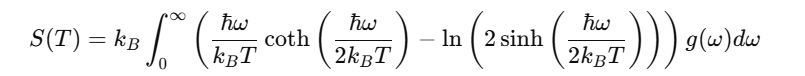

In [ ]:
def phonon_dos(omega, omega_c=10, C=1):
    return C * omega**2 * np.exp(-omega / omega_c)

def entropy(omega, T, kb, hbar):
    x = hbar*omega / (kb*T)
    return (x / np.tanh(x / 2) - np.log(2 * np.sinh(x / 2))) * phonon_dos(omega)

entropy_value = kB * f.trapezoidal_function(
    f=entropy,
    xmin=omega_min,
    xmax=omega_max,
    n=n,
    T=T,
    kb=kB,
    hbar=hbar)
entropy_value

8.273604057693148e-19

In [28]:
def entropy_integrand(omega, T=273, kb=1.38e-23, hbar=1.05e-34):
    x = hbar * omega / (kb * T)
    return (x / np.tanh(x / 2) - np.log(2 * np.sinh(x / 2))) * phonon_dos(omega)

kB * quad(entropy_integrand, omega_min, omega_max)[0]

8.276089556109981e-19

In [40]:
%%writefile parallel_entropy.py

# Import Library
from mpi4py import MPI
import numpy as np
import argparse
import functions as f

# Constants
hbar = 1.054e-34
kB = 1.38e-23

# Parser
parser = argparse.ArgumentParser()
parser.add_argument('--xmin', type=float, help='Lower bound of the integral')
parser.add_argument('--xmax', type=float, help='Upper bound of the integral')
parser.add_argument('--n', type=int, help='Number of points in the integral')
parser.add_argument('--T', type=int, help='Temperature')
args = parser.parse_args()
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

# Chunk range
N = args.xmax - args.xmin
chunk_size = N // size

start = args.xmin + rank*chunk_size
end = start + chunk_size if rank != size - 1 else args.xmax

global_integral = None
if rank == 0:
    global_integral = np.array([0], dtype=np.float64)

# Main Calculations
entropy_value = kB * f.trapezoidal_function(
    f=f.entropy,
    xmin=start,
    xmax=end,
    n=args.n,
    T=args.T,
    kb=kB,
    hbar=hbar)

comm.Reduce(np.array(entropy_value), global_integral, op=MPI.SUM, root=0)

# Output results
if rank == 0:
    print(f"Entropy: {global_integral[0]}")

Overwriting parallel_entropy.py


In [43]:
!mpiexec -n 8 python parallel_entropy.py --xmin={omega_min} --xmax={omega_max} --n={n} --T=273

Entropy: 8.273604064816872e-19


### Task 2: Enthalpy

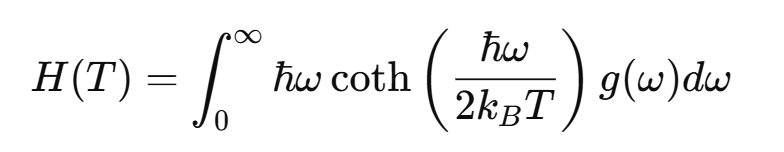

In [62]:
def enthalpy(omega, T, kb, hbar):
    x = hbar*omega / (kb*T)
    return hbar*omega * (1 / np.tanh(x / 2)) * phonon_dos(omega)

@njit
def jit_enthalpy(omega, T, kb, hbar):
    x = hbar*omega / (kb*T)
    return hbar*omega * (1 / np.tanh(x / 2)) * 1 * omega**2 * np.exp(-omega / 10)


In [65]:
enthalpy_value = f.trapezoidal_function(
    f=enthalpy,
    xmin=omega_min,
    xmax=omega_max,
    n=n,
    T=T,
    kb=kB,
    hbar=hbar
)
enthalpy_value

1.506723930450195e-17

In [66]:
enthalpy_value = f.trapezoidal_function(
    f=jit_enthalpy,
    xmin=omega_min,
    xmax=omega_max,
    n=n,
    T=T,
    kb=kB,
    hbar=hbar
)
enthalpy_value

1.506723930450195e-17

In [55]:
def enthalpy_quad(omega, T=273, kb=1.38e-23, hbar=1.054e-34):
    x = hbar*omega / (kb*T)
    return hbar*omega * (1 / np.tanh(x / 2)) * phonon_dos(omega)
quad(func=enthalpy_quad, a=omega_min, b=omega_max)[0]

1.507069251028418e-17

### Task 3: Gibbs Energy

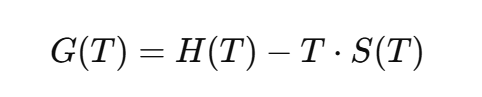

### Task 4: Helmholtz Free Energy

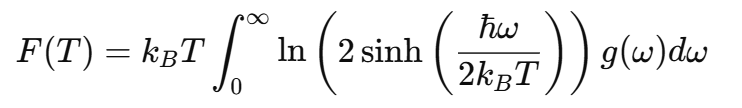

In [ ]:
def trapezoidal_function(f, xmin: int, xmax: float, n: int, **kwargs):
    integral = 0.0
    dx = (xmax - xmin) / (n+1)

    for x in np.linspace(xmin, xmax, n):
        integral += dx * ( f(x, **kwargs) + f(x+dx, **kwargs) )/2
    
    return integral
    
def helmholtz_energy(omega, T, kb, hbar):
    x = hbar*omega / (kb*T)
    return np.log(2 * np.sinh(x / 2)) * 1 * omega**2 * np.exp(-omega / 10)

def gpu_helmholtz_energy(omega, T, kb, hbar):
    x = hbar*omega / (kb*T)
    return cp.log(2 * cp.sinh(x / 2)) * 1 * omega**2 * cp.exp(-omega / 10)

def gpu_trapezoidal_function(f, xmin: int, xmax: float, n: int, **kwargs):
    integral = 0.0
    dx = (xmax - xmin) / (n+1)
    x = cp.linspace(xmin, xmax, n)

    integral = dx * ( f(x, **kwargs) + f(x+dx, **kwargs) )/2
    
    return integral.sum()

In [ ]:
Helm_energy_value = trapezoidal_function(
    f=helmholtz_energy,
    xmin=omega_min,
    xmax=omega_max,
    n=n,
    T=T,
    kb=kB,
    hbar=hbar
)
Helm_energy_value

In [ ]:
GPU_Helm_energy_value = gpu_trapezoidal_function(
    f=gpu_helmholtz_energy,
    xmin=omega_min,
    xmax=omega_max,
    n=n,
    T=T,
    kb=kB,
    hbar=hbar
)
GPU_Helm_energy_value